In [1]:
import joblib
import polars as pl
from loguru import logger
from sklearn import metrics

from lisa.config import MODELS_DIR, PROCESSED_DATA_DIR
from lisa.features import standard_scaler, train_test_split

features_path = PROCESSED_DATA_DIR / "labelled_test_data.csv"
model_path = MODELS_DIR / "labelled_sample/random_forest.pkl"

# Load the model and scaler
logger.info(f"Loading model from {model_path}")
model = joblib.load(model_path)

# Load the dataset
logger.info(f"Loading features from {features_path}")
df = pl.read_csv(features_path)

X_train, X_test, y_train, y_test = train_test_split(df, train_size=0.8, gap=300)

scaled_X_train, scaled_X_test, scaler = standard_scaler(X_train, X_test)


2024-09-02 11:48:34.897 | INFO     | lisa.config:<module>:15 - PROJ_ROOT path is: /Users/tomwilson/code/LISA


2024-09-02 11:48:35.878 | INFO     | __main__:<module>:13 - Loading model from /Users/tomwilson/code/LISA/models/labelled_sample/random_forest.pkl
2024-09-02 11:48:37.583 | INFO     | __main__:<module>:17 - Loading features from /Users/tomwilson/code/LISA/data/processed/labelled_test_data.csv


2024-09-02 11:49:17.942 | INFO     | __main__:<module>:8 - Accuracy: 0.962750282155248
2024-09-02 11:49:18.592 | INFO     | __main__:<module>:9 - Score: 0.962750282155248
2024-09-02 11:49:18.593 | INFO     | __main__:<module>:10 - Confusion Matrix:
[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.52960404 0.         0.47039596]]
2024-09-02 11:49:18.684 | INFO     | __main__:<module>:28 - Saving confusion matrix


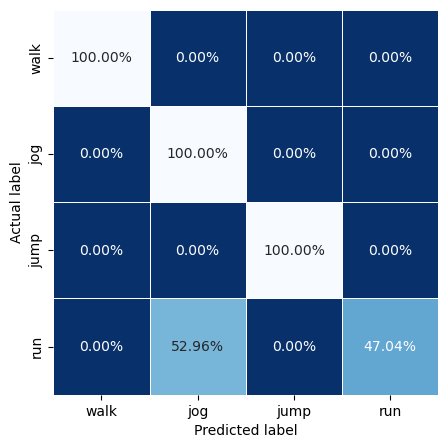

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# evaluate model
labels = df["ACTIVITY"].unique(maintain_order=True)
cm = metrics.confusion_matrix(y_test, model.predict(scaled_X_test), labels=labels, normalize="true")

logger.info("Accuracy: " + str(metrics.accuracy_score(y_test, model.predict(scaled_X_test))))
logger.info("Score: " + str(model.score(scaled_X_test, y_test)))
logger.info("Confusion Matrix:\n" + str(cm))

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt=".2%",
    linewidths=0.5,
    square=True,
    cmap="Blues_r",
    cbar=False,
    xticklabels=labels,
    yticklabels=labels,
    ax=ax
)
ax.set_ylabel("Actual label")
ax.set_xlabel("Predicted label")

logger.info("Saving confusion matrix")

Text(0.5, 1.0, 'Accuracy Score: 0.962750282155248')

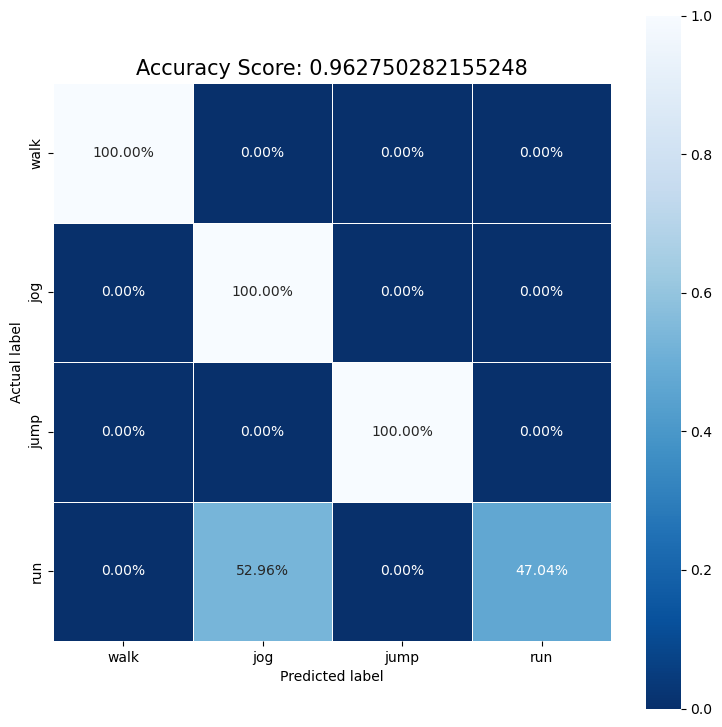

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

labels = df['ACTIVITY'].unique(maintain_order=True)
cm = metrics.confusion_matrix(y_test, model.predict(scaled_X_test), labels=labels, normalize='true')

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Accuracy Score: {str(model.score(scaled_X_test, y_test))}'
plt.title(all_sample_title, size = 15)

In [4]:
# Log the most important features
import numpy as np

feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[::-1]
top_n = 20  # Number of top features to log
feature_names = X_train.columns
logger.info(f"Top {top_n} important features:")
for i in range(top_n):
    print(f"Feature {indices[i]}: {feature_names[indices[i]]} (Importance: {feature_importances[indices[i]]:.4f})")

2024-09-02 11:49:20.595 | INFO     | __main__:<module>:8 - Top 20 important features:
Feature 501: min_accel_pelvis.x (Importance: 0.0595)
Feature 483: min_HighG_pelvis.x (Importance: 0.0594)
Feature 500: max_accel_pelvis.x (Importance: 0.0526)
Feature 485: std_HighG_pelvis.x (Importance: 0.0405)
Feature 482: max_HighG_pelvis.x (Importance: 0.0295)
Feature 395: std_HighG_Thigh_L.x (Importance: 0.0274)
Feature 503: std_accel_pelvis.x (Importance: 0.0261)
Feature 393: min_HighG_Thigh_L.x (Importance: 0.0254)
Feature 170: max_gyro_Shank_L.z (Importance: 0.0212)
Feature 213: min_HighG_Thigh_R.x (Importance: 0.0196)
Feature 233: std_accel_Thigh_R.x (Importance: 0.0159)
Feature 321: min_accel_Shank_R.x (Importance: 0.0159)
Feature 362: max_mag_Shank_R.y (Importance: 0.0143)
Feature 123: min_HighG_Shank_L.x (Importance: 0.0140)
Feature 303: min_HighG_Shank_R.x (Importance: 0.0135)
Feature 125: std_HighG_Shank_L.x (Importance: 0.0128)
Feature 21: min_Global Angle_Foot_L.y (Importance: 0.0125)


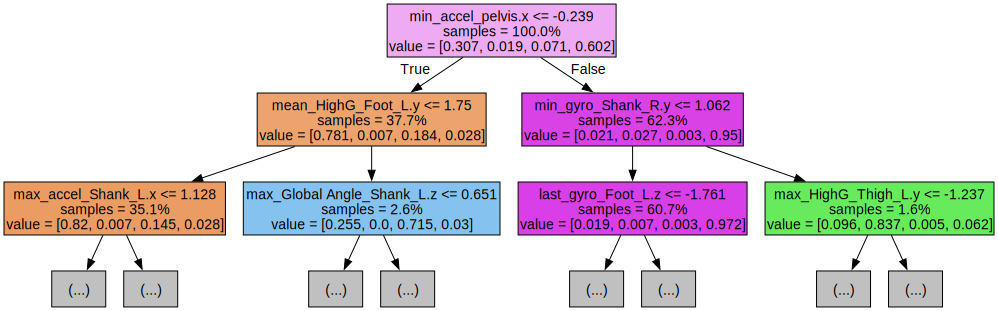

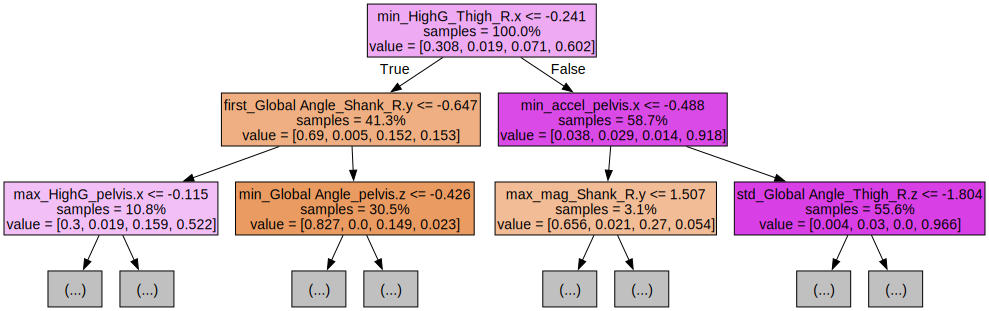

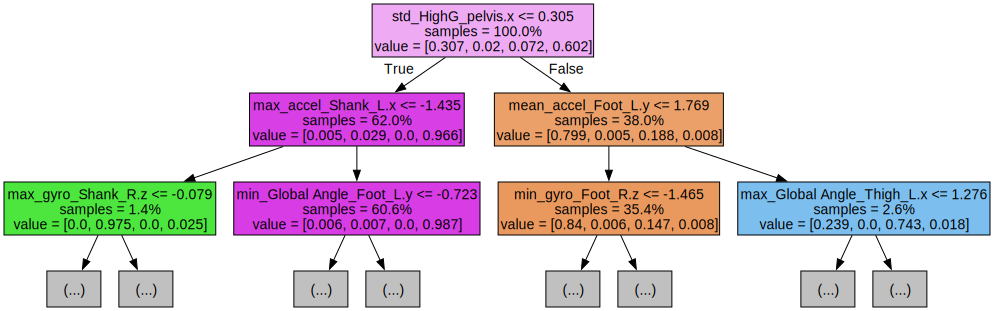

In [5]:
# Visualise trees

# Export the first three decision trees from the forest

from sklearn.tree import export_graphviz
import graphviz

for i in range(3):
    tree = model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)